# Predicting Burlington Housing Prices
### Bryant Crocker 

This analysis pulls data from Burlington's open data socrata page.  I am interested in predicted the value of a single family and residential condo homes.  These are two most frequently sold types of property and tend to be the property category the realtors are most concerned with.  A pricing algorithm will help analysts to value properties and cut down the time required to get a house on the market.

### Import necessary libraries

In [1]:
#for tablular data managment 
import pandas as pd 
#for scientific plotting 
import seaborn as sns 
import matplotlib.pyplot as plt
import quandl
#pythons premiere numerical computing library 
import numpy as np
from sklearn.model_selection import GridSearchCV
plt.style.use('ggplot')
%matplotlib inline
#Read in csv from Burlington Open data
df = pd.read_csv("https://opendata.arcgis.com/datasets/276ccff527454496ac940b60a2641dda_0.csv")
#Split the 'PropertyCenterPoint' column into 'Latitude' and 'Longitude' in a seperate dataframe
df2 = df['PropertyCenterPoint'].str.strip('()').str.split(', ', expand=True).rename(columns={0:'Latitude', 1:'Longitude'})
df3 = df['Baths'].str.split('/', expand=True).rename(columns={0:'Full_Baths', 1:'Half_Baths'})
# create a dataframe with the new variables
df = pd.concat([df, df2, df3],axis=1)
df.drop('PropertyCenterPoint', 1, inplace = True)
df['Half_Baths'] = pd.to_numeric(df['Half_Baths'])
df['Full_Baths'] = pd.to_numeric(df['Full_Baths'])
df['SaleDate'] = pd.to_datetime(df['SaleDate'])
df['Year'] = df['SaleDate'].apply(lambda row: row.year)
df = df[df['Year'] > 1996]
mydata = quandl.get("FRED/VTNGSP", start_date="1931-01-01")
mydata2 = quandl.get("FRED/VTSTHPI", start_date="1931-01-01")
mydata = mydata.reset_index()
mydata2 = mydata2.resample('A').mean()
mydata2 = mydata2.reset_index()
mydata['Year'] = mydata['Date'].apply(lambda row: row.year)
mydata2['Year'] = mydata2['Date'].apply(lambda row: row.year)
mydata = mydata.rename(columns = {'Value': 'VermontGDP'})
mydata2 = mydata2.rename(columns = {'Value': 'VermontHPI'})
mydata = mydata.drop('Date', 1)
mydata2 = mydata2.drop('Date', 1)
df = df.merge(mydata, 'left', on = 'Year')
df = df.merge(mydata2, 'left', on = 'Year')
print("Dataframe dimensions:", df.shape)

Dataframe dimensions: (4605, 45)


In [2]:
df.head()

,AccountNumber,ParcelID,SpanNumber,StreetNumber,AlternateNumber,StreetName,Unit,CuO1LastName,CuO1FirstName,CuO2LastName,...,Foundation,Depreciation,FID,Latitude,Longitude,Full_Baths,Half_Baths,Year,VermontGDP,VermontHPI
0,7526,049-4-002-000,114-035-17526,69,NaN,MARBLE AV,NaN,DANGL,JON B,HOWARD,...,BS,0.359,1004,-73.2122,44.4691,1,0,2010.0,27108.4,441.0550
1,3935,039-4-136-000,114-035-13935,25,NaN,ST LOUIS ST,NaN,CHALMER,JUDITH R,GIBBONS,...,BS,0.098,1005,-73.2125,44.48854,1,1,2007.0,24696.8,457.9450
2,283,021-2-211-133,114-035-10283,133,NaN,NORTHSHORE DR,Unit 133,BATES,TIMOTHY M,BATES,...,S,0.025,1006,-73.2681,44.52157,2,1,2010.0,27108.4,441.0550
3,6202,045-2-220-000,114-035-16202,14,NaN,ADSIT CT,NaN,NOT AVAILABLE,NaN,NaN,...,BS,0.174,1007,-73.2051,44.48153,1,1,2013.0,29098.8,438.5850
4,3657,038-4-015-000,114-035-13657,237,NaN,NORTH AV,NaN,"PACKARD LOFTS, LLC",NaN,NaN,...,S,0.000,1009,-73.2258,44.4877,44,4,2005.0,23509.3,413.1875


To start things off I will examine the main variable of interest, Sale Price.  As we can see the distribution of sale prices is extremely skewed.  This is somewhat expected for housing prices.  There are some that sell for extremely high values but most cluster around a lower value. 

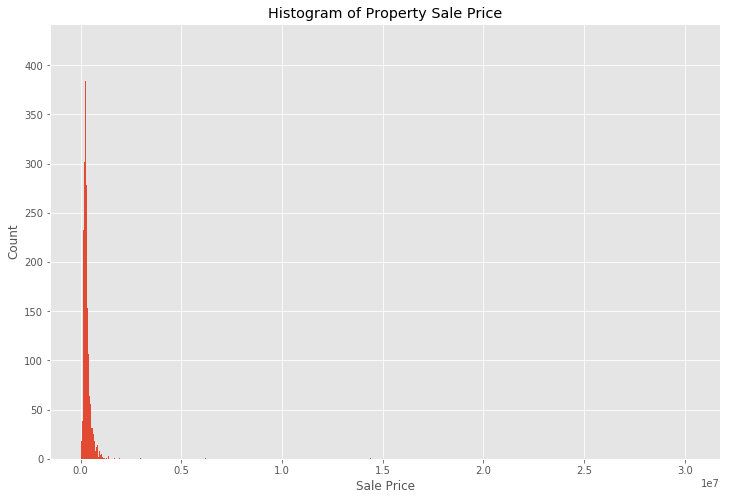

In [3]:
plt.figure(figsize = (12,8))
df['SalePrice'].hist(bins = 'auto')
plt.title("Histogram of Property Sale Price")
plt.xlabel('Sale Price')
plt.ylabel('Count')
plt.savefig("saleprice.png")
plt.show()

Zooming in a bit, limiting the distribution to values less than 2000000 makes the skew clearer

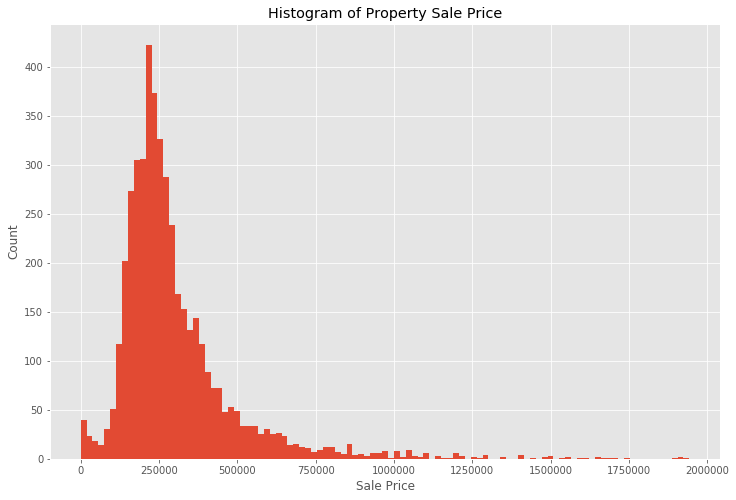

In [4]:
mil = df[df['SalePrice'] < 2000000]
plt.figure(figsize = (12,8))
mil['SalePrice'].hist(bins = 'auto')
plt.title("Histogram of Property Sale Price")
plt.xlabel('Sale Price')
plt.ylabel('Count')
plt.savefig("saleprice.png")
plt.show()

The Skew can also be easily seen in a boxplot.  There are many points that are above 1.5 IQRs from the 75th quantile.

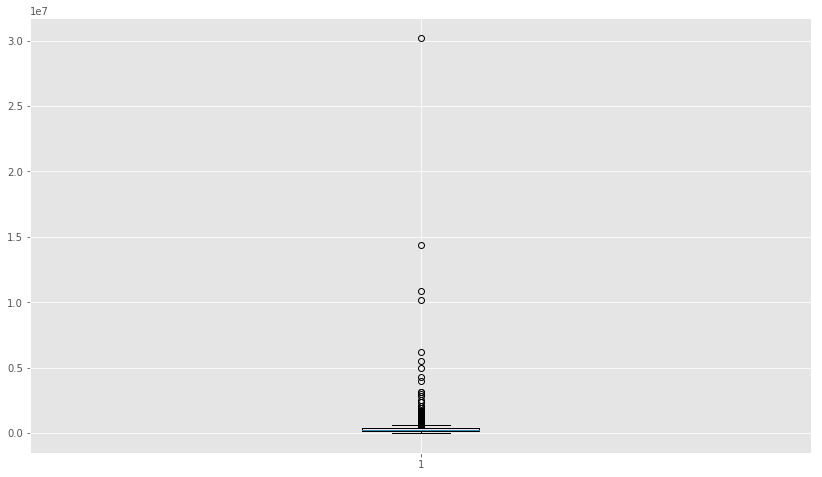

In [5]:
plt.figure(figsize = (14, 8))
plt.boxplot(df['SalePrice'])
plt.show()

We'd prefer to have a symetric distribution like the one simulated below.

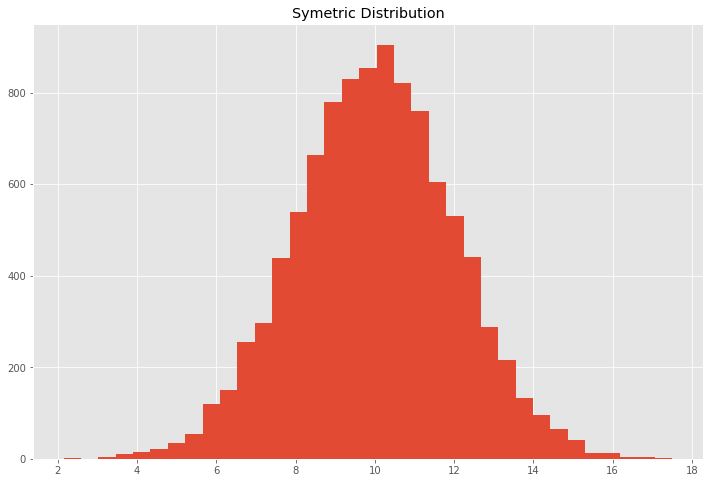

In [6]:
plt.figure(figsize = (12,8))
X = np.random.normal(10, 2, 10000)
plt.hist(X, bins = 35)
plt.title('Symetric Distribution')
plt.savefig('symetricexample.png')
plt.show()

I next put together a matplotlib figure with various plots to get an idea of the data.  Something worth noting, is that the two most common kinds of land use are Resiential condo and Single Family homes. After noticing this in the plot I decided to first focus on just prediciting the prices for these kinds of units.  I know from domain knowledge (living around Burlington for my whole life) that these two types of units are fairly similar and also sell for similar prices.  

### EDA plotting

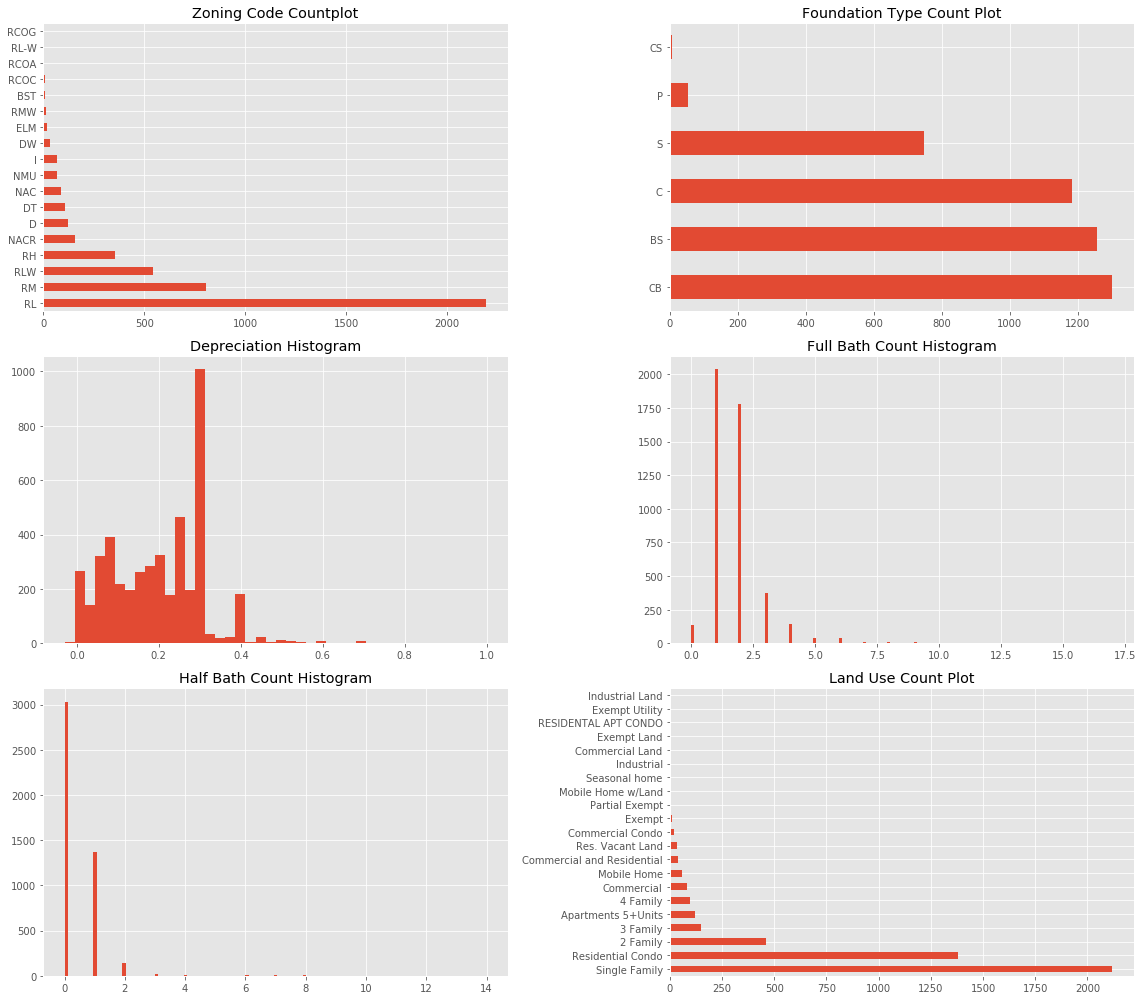

In [7]:
#layout a large plotting grid and plot several important columns
plt.figure(figsize = (16,14))
plt.subplot(321)
df['ZoningCode'].value_counts().plot(kind="barh", color='C0')
plt.title('Zoning Code Countplot')
plt.subplot(322)
df['Foundation'].value_counts().plot(kind="barh", color = 'C0')
plt.title("Foundation Type Count Plot")
plt.subplot(323)
df['Depreciation'].hist(bins='auto')
plt.title("Depreciation Histogram")
plt.subplot(324)
index = df.loc[:,'Full_Baths'] < 20 
df.Full_Baths[index].hist(bins='auto')
plt.title("Full Bath Count Histogram")
plt.subplot(325)
index = df.loc[:,'Half_Baths'] < 20 
df.Half_Baths[index].hist(bins = 'auto')
plt.title("Half Bath Count Histogram")
plt.subplot(326)
df['LandUse'].value_counts().plot(kind="barh", color ='C0')
plt.title("Land Use Count Plot")
plt.tight_layout()
plt.savefig("EDAfig.png")
plt.show()


I next wanted to look at the count of houses sold in Burlington Over Time. It is easuly to see visually that the count of houses sold each month has gradually increased over time.  The time Series is a bit noisy.

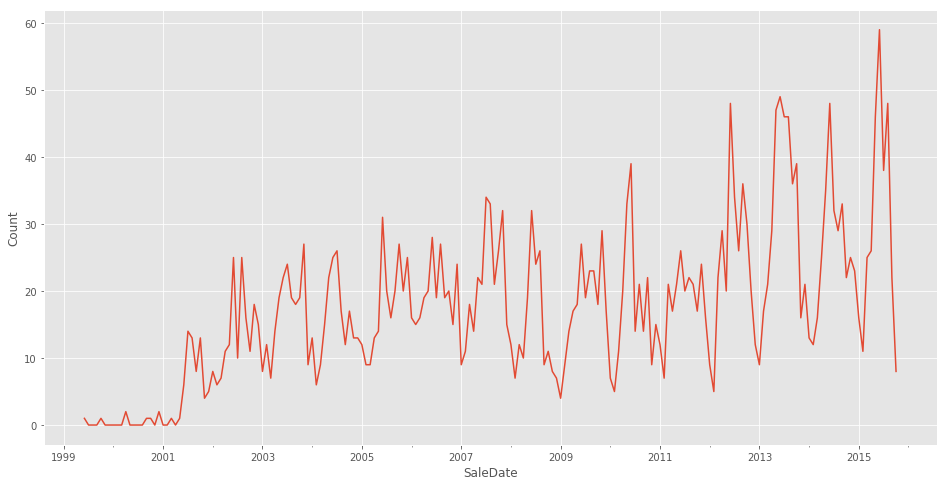

In [8]:
interest = df[['SaleDate', 'SalePrice','CurrentValue', 'Latitude', 'Longitude', 'LandUse', 'YearBlt']].dropna()
interest['SaleDate'] = pd.to_datetime(interest['SaleDate'])
interest = interest[(interest['LandUse'] == "Single Family") | (interest['LandUse'] == "Residential Condo")]
interest.set_index('SaleDate', inplace = True)
interest2 = interest[interest.index > pd.to_datetime('1998-12-31')]
plt.figure(figsize = (16,8))
x = interest2.SalePrice.resample('M').count()
x.plot()
#if do by year needed to make time series not have weird x ticks
#plt.ticklabel_format(useOffset=False)
plt.ylabel("Count")
plt.show()

I use the seaonal_decompose module of statsmodels to decompose the time series and visualize the seasonality and trend. It is easy to see visually that the there is an upward trend. There's a strong seasonal effect present in this time series.  It appears that there is a larger count of sales during the summer month in Burlington.  This is expected because Burlington winters are cold and many people are not as willing to see and sell houses.

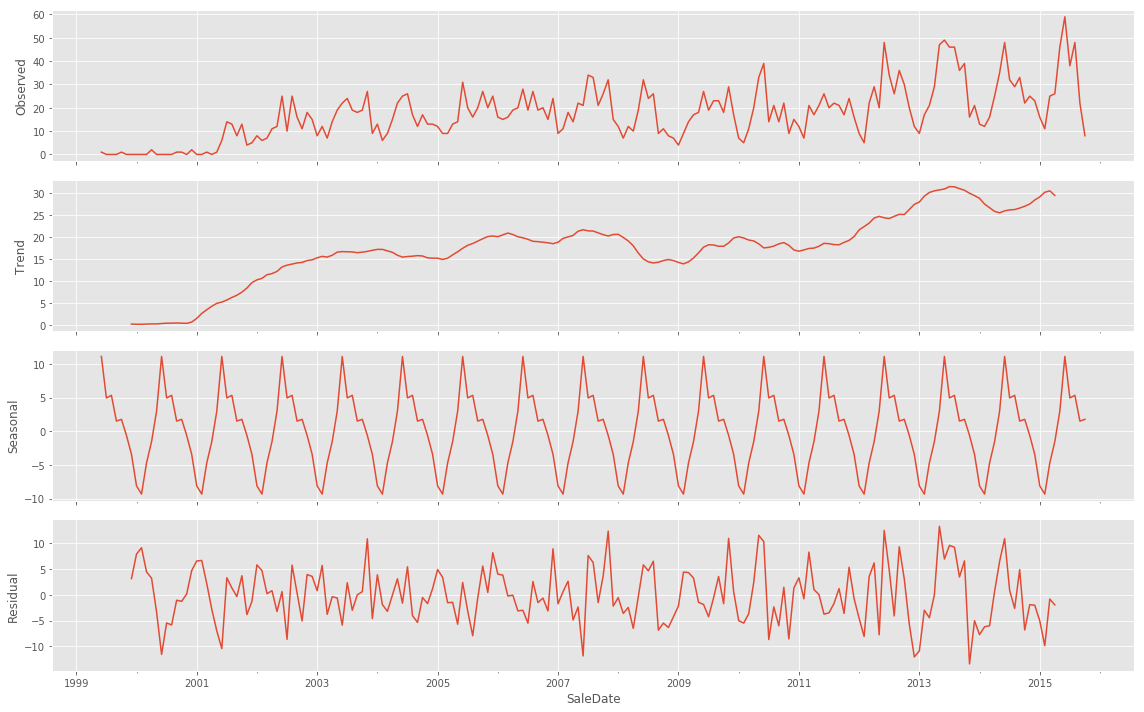

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
rcParams['figure.figsize'] = 16, 10
result = seasonal_decompose(x, model='additive')
result.plot()
plt.savefig('decomp.png')
plt.show()

I next overlay the trend extracted over the noisy time series.  This helps to smooth the series and see a more general trend.

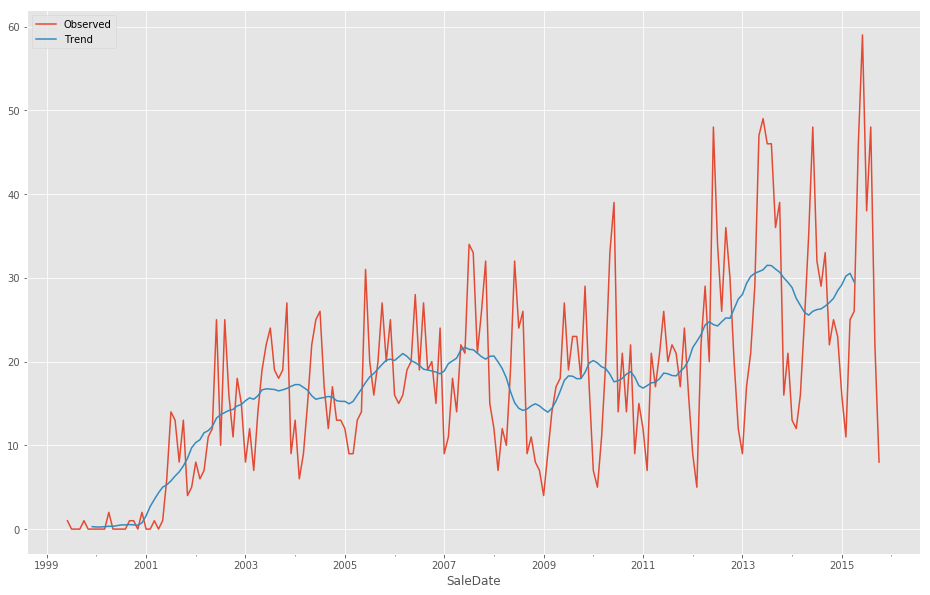

In [10]:
x.plot(label = 'Observed')
result.trend.plot(label = 'Trend')
plt.legend(loc = 'upper left')
plt.savefig('TrendOvertime.png')

I was also interested in when Burlington Homes were built.  The plot below compares homes built by year to homes sold by year.  I don't really see any meaningful trends here but this is still important to visualize.

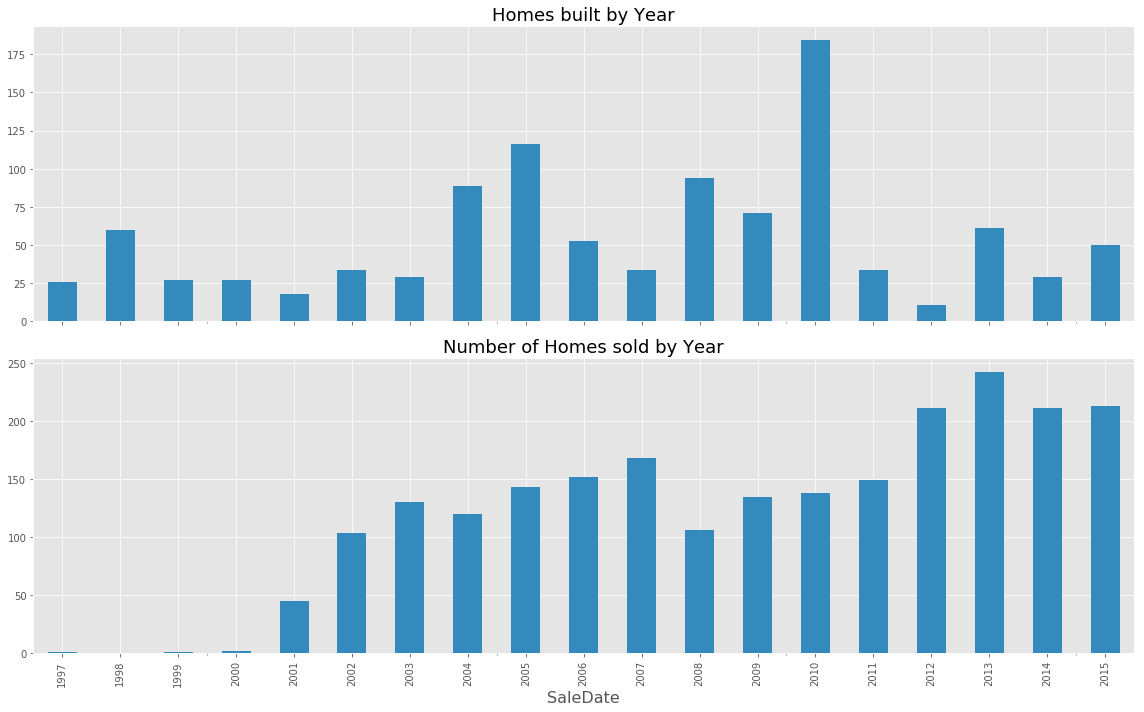

In [11]:
interest = interest[interest['YearBlt'] > 1950]
y = interest.groupby('YearBlt').count()
fig, ax = plt.subplots(2,1, figsize = (16,10), sharex=True)
ax= ax.ravel()
y2 = y[y.index > 1978]
y2['Latitude'].plot(kind = 'bar',  color = 'C1',ax = ax[0])
ax[0].set_title("Homes built by Year", size = 18)
ax[0].set_xlabel("Year Built", size = 16)
plt.title("Number of Homes sold by Year", size = 18)
plt.xlabel("Year Built", size = 16)
z = interest.SalePrice.resample('A').count()
z.index = z.index.year
z.plot(kind='bar', color = 'C1', ax = ax[1])
plt.tight_layout()
plt.savefig('homesbyyear.png')
plt.show()

The following plot looks at the average sale price by year built.  It appears that housese built in 2009 are worth more than houses in the past years or after.  I wonder what was special about the properties built this year.

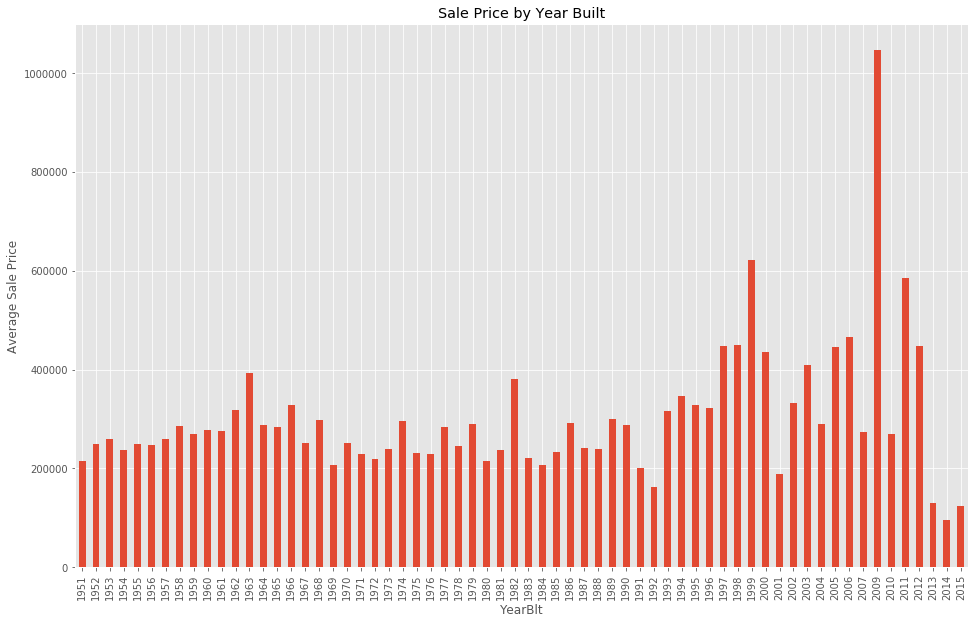

In [12]:
interest.groupby('YearBlt')['SalePrice'].mean().plot(kind='bar', color = 'C0')
plt.title('Sale Price by Year Built')
plt.ylabel('Average Sale Price')
plt.show()


The last plot used to explore the data was a time series plot of the median housing price of Burlington housing over time. It appears that the median sale price increased over the early 2000s but flattened out around 2007 and has remained relativley flat since then.

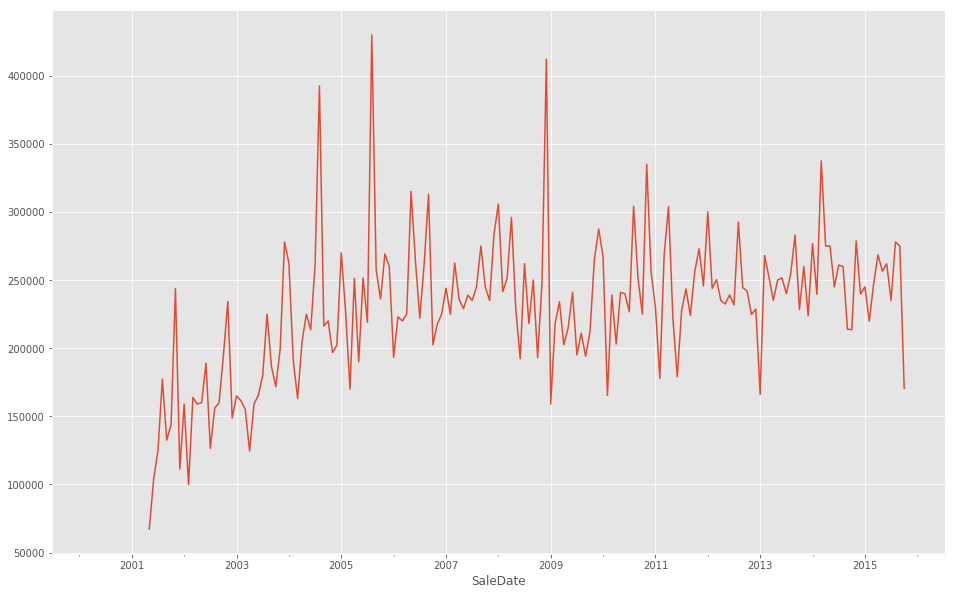

In [13]:
interest = interest.resample('m').median()
interest = interest[interest.index > pd.to_datetime('01/01/2000')]
interest['SalePrice'].plot()
plt.show()

# Modeling 

To try to predict Burlington housing pricies I will use a few different supervised learned models.  A supervised learning problem is consists of a target variable Y, in this case 'SalePrice' and a matrix of predictor variables X. The target variable is predicted using the X matrix.  Before fitting an alorgitm to the data I split the data into training and test sets. The purpose behind this is to evaluate the model on data that it has not seen to get a more realistic estimate of it's accuracy.

Predicting Housing 'SalePrice' is a supervised regression problem becasue the target is continuous.


In [66]:
df['SaleDate'] = pd.to_datetime(df['SaleDate'])
modeldf = df.drop(['AccountNumber', 'ParcelID', 'SpanNumber', 'StreetNumber',
       'AlternateNumber', 'Unit', 'CuO1LastName',
       'CuO1FirstName', 'CuO2LastName', 'CuO2FirstName', 'CuO3LastName',
       'CuO3FirstName','LegalReference', 'GrantorLastName', 'FID', 'Baths'], axis = 1)
modeldf['Latitude'] = pd.to_numeric(modeldf['Latitude'])
modeldf['Longitude'] = pd.to_numeric(modeldf['Longitude'])
#modeldf['Sale_Year'] = modeldf['SaleDate'].apply(lambda row: row.year)
modeldf.drop('SaleDate', axis=1, inplace= True)
modeldf = modeldf[(modeldf['LandUse'] == "Single Family") | (modeldf['LandUse'] == "Residential Condo")]
modeldf = modeldf[modeldf['SalePrice']> 0]
modeldf.dropna(inplace = True)
#pulled cityhall gps coords from this https://www.maps.ie/coordinates.html
from geopy.distance import great_circle
distances = []
for i, j in zip(modeldf['Latitude'], modeldf['Longitude']):
    val = (i, j)
    Cityhall = (44.47647568031712, -73.21353835752235)
    dist = great_circle(val,Cityhall).miles
    distances.append(dist)
modeldf['Distances'] = distances

In [99]:
modeldf.drop('Date', 1, inplace = True)

KeyError: "['Date'] not found in axis"

### Decision Tree

Decison trees recursivley break up the sample space to produce estimates and can be visualized with a tree like structure. Decisons trees tend to overfit the training set and not peform super well on test sets.  They are quite powerful models because they can be easily visualized and interpretted by the analyst.

In [67]:
modeldf.dropna(inplace = True)
modeldf = pd.get_dummies(modeldf)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import StandardScaler
target_name = 'SalePrice'
Xframe = modeldf.drop(['SalePrice'], axis=1)
data_names = Xframe.columns
standard_scaler = StandardScaler()
X = standard_scaler.fit_transform(Xframe)
y=modeldf[target_name]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30, random_state=123)

/anaconda3/envs/Main/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/Main/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [17]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
DecisionTree = tree.DecisionTreeRegressor()
DecisionTree.fit(X_train, y_train)
cv_scores = cross_val_score(DecisionTree, X_train, y_train, cv = 10)
DCTreePrediction = DecisionTree.predict(X_test)

another way this could be done is using a pipeline. I don't really like to use pipelines when not necessary so I won't really use them for much of this, since I am just scaling and fitting models.

In [18]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([
                ('scaler', StandardScaler()),
                ('tree', DecisionTreeRegressor())
            ])
pipe.fit(X_train, y_train)
cv_scores = cross_val_score(pipe, X_train, y_train, cv = 10)
for i in cv_scores:
    print(i)

0.7435373177618289
0.8378838529688248
0.7777473662576421
0.14488024950425094
0.799256855756526
0.7226954567234497
0.692062159313461
0.8347926553733305
0.8371807802808641
0.5287771145156441


### Decision Tree Cross-Valadation Scores:

In [19]:
#some fit well others don't
for score in cv_scores:
    print(score)
(cv_scores.mean())

0.7435373177618289
0.8378838529688248
0.7777473662576421
0.14488024950425094
0.799256855756526
0.7226954567234497
0.692062159313461
0.8347926553733305
0.8371807802808641
0.5287771145156441


0.6918813808455823

One of the most useful things about decisions trees is that they produce variable importance esitimates.  These estimate how much a model would change by removing a variable.

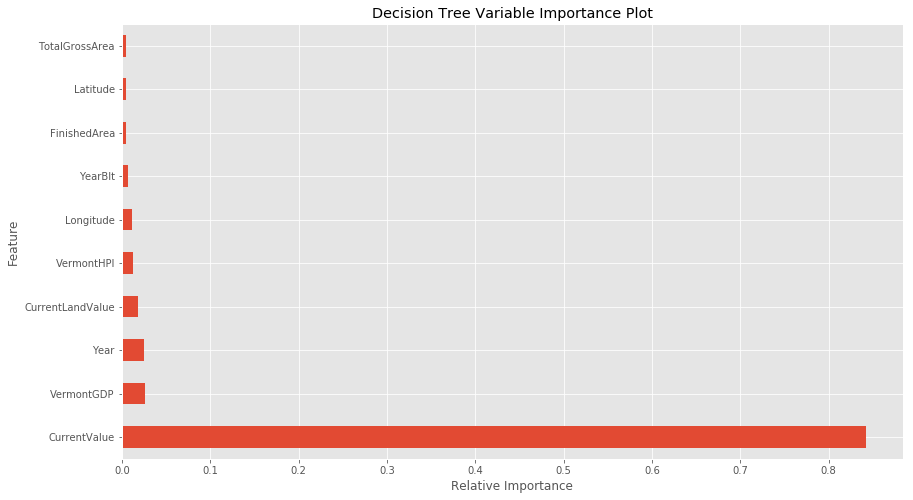

In [20]:
#Importance plot 
columnNames = Xframe.columns
importances = DecisionTree.feature_importances_
combined = {'Feature': columnNames, 'imp': importances}
imp = pd.DataFrame(data=combined).sort_values(by = ['imp'], ascending=False)

imp.iloc[0:10,:].plot(x = 'Feature', y= 'imp',kind='barh', legend = False, figsize = (14,8), color = "C0")
plt.title("Decision Tree Variable Importance Plot")
plt.xlabel("Relative Importance")
plt.show()

### Random Forest 

The Random Forest algorithm fits multiple decision trees on bootstrapped samples of the training set data.  The predicted value is the mean of all teh trees end nodes.  Random forests tend to much better on test sets than decision trees.  The Random Forest is my personal favorite supervised machine learing algorithm.

In [21]:
from sklearn.ensemble  import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
rfmodel = RandomForestRegressor(n_jobs=-1)
rfmodel.fit(X_train, y_train)
cv_scores = cross_val_score(rfmodel, X_train, y_train, cv = 10)
rfpmodel = rfmodel.predict(X_test)

/anaconda3/envs/Main/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [22]:
#some fit well others don't
for score in cv_scores:
    print(score)
(cv_scores.mean())

0.8408110504111066
0.8394665514747158
0.9103130724160378
0.8720748954358719
0.8549077962246822
0.8054649000939375
0.8015535979881357
0.8626340725446365
0.8802087101791568
0.8892762842792081


0.8556710931047489

### Random Forest Random Search

Here I attempt to tune the random forest's hyperperamters.  Hyperperamters are external model peramters that control how it fits to the data. Tuning peramters correctly increases accuracy and fights overfitting.

In [107]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 500, num = 4)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
              

# run randomized search
n_iter = 100
random_search = RandomizedSearchCV(rfmodel, cv = 3, param_distributions=param_dist,
                                   n_iter=n_iter, n_jobs=-1)
random_search.fit(X_train, y_train)
bestmodel = random_search.best_estimator_
random_search_pred = bestmodel.predict(X_test)
scores = []
random_search.best_score_

/anaconda3/envs/Main/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/anaconda3/envs/Main/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/anaconda3/envs/Main/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/anaconda3/envs/Main/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky

0.8829639406405201

# Top Random Forest Paramters

In [48]:
random_search.best_params_

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 110,
 'bootstrap': True}

In [77]:
#here's some other params I tried

In [71]:
params_rf = {'n_estimators' : [100, 350, 500],
            'max_features': ['log2', 'auto', 'sqrt'],
            'min_samples_leaf': [2, 10, 30],
            "min_samples_split": [3,5,7,9,11]}
# Import GridSearchCV

# Instantiate grid_rf
grid_rf = GridSearchCV(estimator=rfmodel,
                       param_grid=params_rf,
                       cv=3,
                       verbose=0,
                       n_jobs=-1)

grid_rf.fit(X_train,y_train)
bestmodel = grid_rf.best_estimator_
random_search_pred = bestmodel.predict(X_test)
grid_rf.best_score_

0.87524250431662365

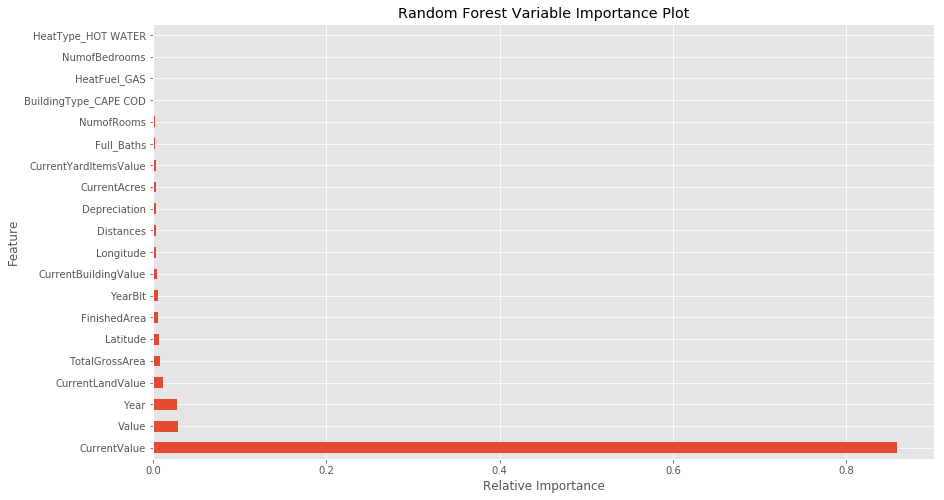

In [49]:
#Importance plot 
columnNames = Xframe.columns
importances = bestmodel.feature_importances_
combined = {'Feature': columnNames, 'imp': importances}
imp = pd.DataFrame(data=combined).sort_values(by = ['imp'], ascending=False)

imp.iloc[0:20,:].plot(x = 'Feature', y= 'imp',kind='barh', legend = False, figsize = (14,8),color='C0')
plt.title("Random Forest Variable Importance Plot")
plt.xlabel("Relative Importance")
plt.show()

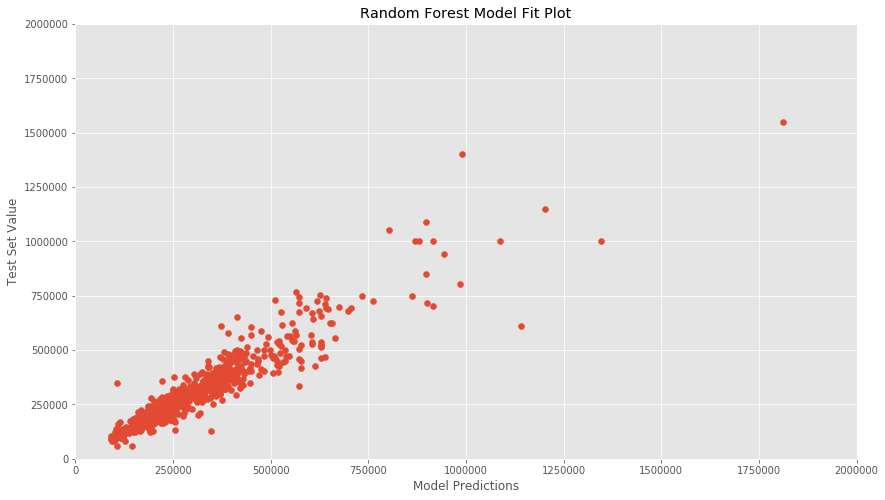

In [50]:
plt.figure(figsize = (14,8))
plt.scatter(rfpmodel, y_test, color = 'C0')
#plt.plot([rfpmodel.min(), rfpmodel.max()], [y_test.min(), y_test.max()], 'k--', lw=6)
plt.ylabel("Test Set Value")
plt.xlabel("Model Predictions")
plt.xlim(0, 2000000)
plt.ylim(0, 2000000)
plt.title("Random Forest Model Fit Plot")
plt.show()

### Gradient Boosted Tree Model

In [54]:
from sklearn.ensemble import GradientBoostingRegressor
clf = GradientBoostingRegressor(n_estimators=500).fit(X_train, y_train)

clf.score(X_test, y_test)

cv_scores = cross_val_score(clf, X_train,y_train,n_jobs=-1, cv = 10)
gradient_score = clf.predict(X_test)
for score in cv_scores:
    print(score)
print("mean score:", np.mean(cv_scores))

0.8322488346406745
0.8651085467663939
0.9265847884220776
0.890569131549256
0.8442721822382772
0.7688546836400553
0.8589192267798409
0.886475079310507
0.9092267219042041
0.8899194454770972
mean score: 0.8672178640728385


# Tuning the Tree 

In [55]:
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
param_dist = {"max_depth": [3, None, 5, 10 ,15, 30],
              "max_features": sp_randint(1, 30),
              "min_samples_split": sp_randint(2, 30),
              "min_samples_leaf": sp_randint(1, 30),
            "learning_rate" : np.linspace(0.000000001,1, 100)}
              
clf = GradientBoostingRegressor(n_estimators=100)
# run randomized search
n_iter = 100
random_search = RandomizedSearchCV(clf, cv = 5, param_distributions=param_dist,
                                   n_iter=n_iter, n_jobs=-1)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'max_depth': [3, None, 5, 10, 15, 30], 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a1e0f8470>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a1e0f8dd8>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a2066fb70>, 'learning_rate': array([1.00000e-09, 1.01010e-02, ..., 9.89899e-01, 1.00000e+00])},
          pre_dispatch='2*n_jobs', random_st

In [56]:
random_search.best_score_

0.859321733305196

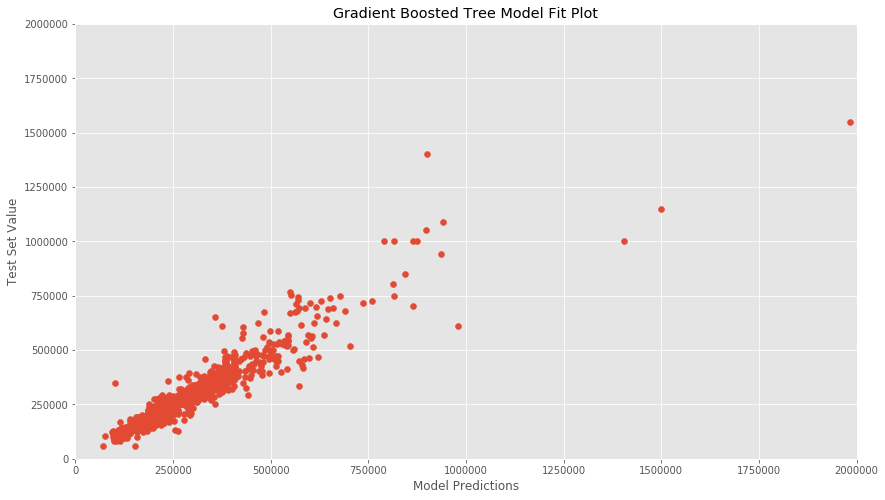

In [58]:
plt.figure(figsize = (14,8))
plt.scatter(gradient_score, y_test, color = 'C0')
plt.ylabel("Test Set Value")
plt.xlabel("Model Predictions")
plt.title("Gradient Boosted Tree Model Fit Plot")
plt.xlim(0, 2000000)
plt.ylim(0, 2000000)
plt.show()

In [62]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

rms = sqrt(mean_squared_error(y_test, DCTreePrediction))
print("Decision Tree RMSE:", rms)

rms = sqrt(mean_squared_error(y_test, rfpmodel))
print("Random Forest RMSE:", rms)
print(r2_score(y_test, rfpmodel))
rms = sqrt(mean_squared_error(y_test, random_search_pred))
print("Tuned Random Forest RMSE:", rms)

rms = sqrt(mean_squared_error(y_test, gradient_score))
print("Boosted Tree RMSE:", rms)


Decision Tree RMSE: 85481.95249211961
Random Forest RMSE: 69774.7195954067
0.8439207021188857
Tuned Random Forest RMSE: 67136.49651597557
Boosted Tree RMSE: 63167.39165622806


In [71]:
Underprice = [] 
for i, j in zip(modeldf.SalePrice, modeldf.CurrentValue):
    if i < j:
        Underprice.append(0)
    else: 
        Underprice.append(1)
modeldf['Underprice'] = Underprice
modeldf['Underprice'].value_counts()
modeldf.drop(['SalePrice'], 1, inplace=True)
modeldf['Underprice'].value_counts().plot(kind='barh', color = 'C0')
plt.show()

AttributeError: 'DataFrame' object has no attribute 'SalePrice'

In [72]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
y = modeldf['Underprice']
Xframe= modeldf.drop('Underprice', axis=1)
standard_scaler = StandardScaler()
X = standard_scaler.fit_transform(Xframe.values)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30, random_state=123)


              precision    recall  f1-score   support

           0       0.59      0.59      0.59       285
           1       0.84      0.84      0.84       738

   micro avg       0.77      0.77      0.77      1023
   macro avg       0.72      0.72      0.72      1023
weighted avg       0.77      0.77      0.77      1023



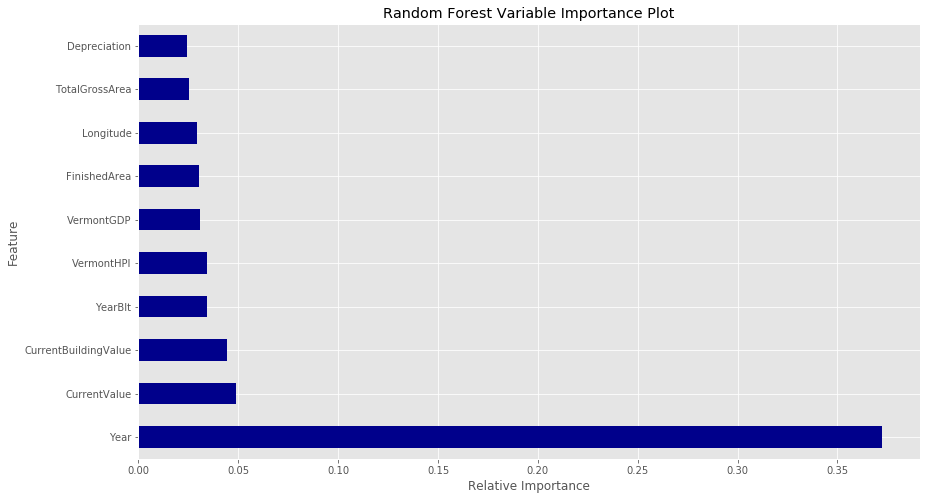

In [73]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
dc = DecisionTreeClassifier()
dc.fit(X_train, y_train)
c = cross_val_score(dc, X_train,y_train,n_jobs=-1, cv = 10)
preds = dc.predict(X_test)
print(classification_report(y_test, preds))
columnNames = Xframe.columns
importances = dc.feature_importances_
combined = {'Feature': columnNames, 'imp': importances}
imp = pd.DataFrame(data=combined).sort_values(by = ['imp'], ascending=False)

imp.iloc[0:10,:].plot(x = 'Feature', y= 'imp',kind='barh', legend = False, figsize = (14,8),color='darkblue')
plt.title("Random Forest Variable Importance Plot")
plt.xlabel("Relative Importance")
plt.show()


In [74]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

dc = RandomForestClassifier(class_weight='balanced')
dc.fit(X_train, y_train)
cv_scores = cross_val_score(dc, X_train,y_train,n_jobs=-1, cv = 10)
preds = dc.predict(X_test)
print(classification_report(y_test, preds))
print(accuracy_score(y_test, preds))

/anaconda3/envs/Main/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.77      0.60      0.67       285
           1       0.86      0.93      0.89       738

   micro avg       0.84      0.84      0.84      1023
   macro avg       0.81      0.76      0.78      1023
weighted avg       0.83      0.84      0.83      1023

0.8387096774193549


In [67]:
params_rf = {'n_estimators' : [100, 350, 500],
            'max_features': ['log2', 'auto', 'sqrt'],
            'min_samples_leaf': [2, 10, 30]}
# Import GridSearchCV

# Instantiate grid_rf
grid_rf = GridSearchCV(estimator=dc,
                       param_grid=params_rf,
                       cv=3,
                       verbose=0,
                       n_jobs=-1)

grid_rf.fit(X_train,y_train)
bestmodel = grid_rf.best_estimator_
random_search_pred = bestmodel.predict(X_test)
grid_rf.best_score_
print(classification_report(y_test, random_search_pred))

              precision    recall  f1-score   support

  AboveValue       0.85      0.96      0.90       738
  BelowValue       0.83      0.58      0.68       285

   micro avg       0.85      0.85      0.85      1023
   macro avg       0.84      0.77      0.79      1023
weighted avg       0.85      0.85      0.84      1023



In [112]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

dc = RandomForestClassifier(class_weight = "balanced_subsample")
dc.fit(X_train, y_train)
cv_scores = cross_val_score(dc, X_train,y_train,n_jobs=-1, cv = 10)
preds = dc.predict(X_test)
print(classification_report(y_test, preds))

/anaconda3/envs/Main/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

  AboveValue       0.85      0.94      0.89       738
  BelowValue       0.79      0.55      0.65       285

   micro avg       0.83      0.83      0.83      1023
   macro avg       0.82      0.75      0.77      1023
weighted avg       0.83      0.83      0.82      1023



In [71]:
from sklearn.linear_model import SGDClassifier
linear_classifier = SGDClassifier()
parameters = {'alpha':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1], 
             'loss':['hinge', 'log'], 'penalty':['l1','l2']}
searcher = GridSearchCV(linear_classifier, parameters, cv=10)

searcher.fit(X_train, y_train)

SGDpred = searcher.predict(X_test)
print(classification_report(y_test, SGDpred))

/anaconda3/envs/Main/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/anaconda3/envs/Main/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/anaconda3/envs/Main/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they de

              precision    recall  f1-score   support

  AboveValue       0.83      0.96      0.89       738
  BelowValue       0.81      0.48      0.60       285

   micro avg       0.82      0.82      0.82      1023
   macro avg       0.82      0.72      0.74      1023
weighted avg       0.82      0.82      0.81      1023



In [75]:
from sklearn.linear_model import LogisticRegression 
glm = LogisticRegression(class_weight = "balanced")
glm.fit(X_train, y_train)
cv_scores = cross_val_score(glm, X_train,y_train,n_jobs=-1, cv = 10)
preds = glm.predict(X_test)
print(classification_report(y_test, preds))

/anaconda3/envs/Main/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.57      0.64      0.60       285
           1       0.85      0.81      0.83       738

   micro avg       0.76      0.76      0.76      1023
   macro avg       0.71      0.73      0.72      1023
weighted avg       0.77      0.76      0.77      1023



In [76]:
for i in zip(Xframe.columns, list(glm.coef_[0])):
    print(i)

('CurrentAcres', -0.0841442778420791)
('TotalGrossArea', 0.41961227918063726)
('FinishedArea', -0.14911952063704065)
('CurrentValue', -0.5139857722302146)
('CurrentLandValue', 0.07737284139133462)
('CurrentYardItemsValue', 0.02031621525369787)
('CurrentBuildingValue', -0.7958613330494224)
('YearBlt', -0.15461471223931283)
('NumofRooms', 0.15305224525610833)
('NumofBedrooms', 0.16292918564982378)
('NumofUnits', -0.03135521261020341)
('Depreciation', 0.10584940821687516)
('Latitude', -0.2138851446837942)
('Longitude', 0.32215406819858516)
('Full_Baths', 0.1576455831130866)
('Half_Baths', 0.14925490837206012)
('Year', 0.2899342205584698)
('VermontGDP', -0.20230293212563236)
('VermontHPI', 2.004462731338614)
('Distances', 0.2630551987005529)
('StreetName_ADAMS CT', 0.1258525955975483)
('StreetName_ADAMS ST', 0.1413343381210221)
('StreetName_ADSIT CT', 0.05706396505619895)
('StreetName_ALDER LN', 0.032244960839502214)
('StreetName_ALEXIS DR', -0.028212963535708367)
('StreetName_ALFRED ST', 

In [114]:
from sklearn.ensemble import GradientBoostingClassifier
GBC = GradientBoostingClassifier()
GBC.fit(X_train, y_train)
cv_scores = cross_val_score(GBC, X_train,y_train,n_jobs=-1, cv = 10)
preds = GBC.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

  AboveValue       0.85      0.96      0.90       738
  BelowValue       0.84      0.56      0.67       285

   micro avg       0.85      0.85      0.85      1023
   macro avg       0.85      0.76      0.79      1023
weighted avg       0.85      0.85      0.84      1023



In [37]:
searcher.best_score_

0.810359231411863

In [ ]:
#code for later
# Create the dictionary: red_vs_blue
red_vs_blue = {'Obama' : 'blue', 'Romney' : 'red'}

# Use the dictionary to map the 'winner' column to the new column: election['color']
election['color'] = election['winner'].map(red_vs_blue)

# Print the output of election.head()
print(election.head())

In [62]:
from sklearn.linear_model import LogisticRegression 
y = []
for i in range(100):
    choice = np.random.choice(['SPAM', 'HAM'])
    y.append(choice)
y = np.array(y)
X = np.random.normal(100, 12, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y)
glm = LogisticRegression().fit(X_train, y_train.reshape(-1,1))

/anaconda3/envs/Main/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ValueError: Expected 2D array, got 1D array instead:
array=[120.59219066  97.2102365   94.29248564  98.45583951 104.98905249
  92.73358557 111.10494535  83.77195571 103.11612775  89.09173398
 112.67825918  95.9436659  106.21005742 102.23484044 108.55522237
  92.54270899  94.51984446 118.15071501  99.92737821  95.33377659
  88.82044058 109.22222365  92.39405273 101.38264214 100.60186418
  91.6770926   94.0427347   82.14547988 120.91040747 114.33048138
 102.6615008   99.99085003 107.59843024  88.7231326  109.66430743
  96.97596633  81.32326018 104.61287203  71.73134498  97.59262443
  90.49166842 107.76016494 123.42547791  98.92866103 101.32497641
  90.65433583  84.41400253  93.79569861  94.41280144  73.39243197
  92.19349112 116.99350067 118.30813986 113.50545016  85.23422014
 116.72142747  96.02233805  98.72433713 109.58748742 114.39822788
  99.70945131  93.72793614 105.69315214  98.19153864  77.69242308
 117.51504019  86.42520645  92.4046158   59.74223411 101.78674256
  99.08046415  78.55017897  90.67880797 106.06015986  89.54903554].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

array(['HAM', 'HAM', 'SPAM', 'SPAM', 'SPAM', 'HAM', 'SPAM', 'SPAM', 'HAM',
       'HAM', 'HAM', 'SPAM', 'HAM', 'HAM', 'HAM', 'SPAM', 'HAM', 'SPAM',
       'SPAM', 'SPAM', 'SPAM', 'SPAM', 'HAM', 'SPAM', 'HAM', 'SPAM',
       'SPAM', 'SPAM', 'HAM', 'SPAM', 'HAM', 'SPAM', 'SPAM', 'HAM', 'HAM',
       'HAM', 'HAM', 'SPAM', 'SPAM', 'SPAM', 'SPAM', 'SPAM', 'SPAM',
       'HAM', 'SPAM', 'SPAM', 'HAM', 'SPAM', 'SPAM', 'HAM', 'HAM', 'HAM',
       'HAM', 'SPAM', 'SPAM', 'SPAM', 'SPAM', 'SPAM', 'SPAM', 'HAM',
       'HAM', 'SPAM', 'SPAM', 'SPAM', 'SPAM', 'SPAM', 'HAM', 'HAM', 'HAM',
       'SPAM', 'SPAM', 'SPAM', 'HAM', 'SPAM', 'HAM'], dtype='<U4')